In [133]:
#load aiida environment and connect to database
from aiida import load_profile
from aiida.orm import computers
profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [141]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData, ArrayData
from aiida.orm import (Group, load_group, load_node, load_code, groups, Node,
                      WorkChainNode, QueryBuilder, CalcJobNode)
from aiida.engine import submit
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import (kkr_imp_sub_wc, kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc, combine_imps_wc,
                                 kkr_flex_wc)
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, VoronoiCalculation, KkrCalculation
import matplotlib.pyplot as plt
from aiida_kkr.tools.common_workfunctions import get_username
from masci_tools.io.common_functions import get_Ry2eV
from aiida_kkr.tools import kkrparams, plot_kkr
import tarfile
import matplotlib as mpl


In [142]:
'<NEWVERSION_BDG>' in kkrparams().values.keys()

True

In [143]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals
from builtins import object, str
from six.moves import range
from six.moves import input
from masci_tools.io.common_functions import open_general
from masci_tools.io.common_functions import search_string
import numpy as np
from masci_tools.io.common_functions import get_alat_from_bravais
from masci_tools.io.common_functions import vec_to_angles
from aiida.common.constants import elements as PeriodicTableElements
_atomic_numbers = {data['symbol']:num for num,
                data in PeriodicTableElements.items()}
load_stuc = load_node(234)
load_stuc

<StructureData: uuid: c1626804-5b71-450c-91c4-aa7197d85279 (pk: 234)>

In [161]:
struc_Bi2Te3= load_node(234)
site_pos_0=None
i=0
for site in struc_Bi2Te3.sites:
    if i==0:
        site_pos_0 = np.array(site.position)
        i += 1
    pos= np.array(site.position)    
    dist_cent = np.sqrt(np.sum(np.square(site_pos_0-pos)))
    print(f"Kind name: ({site.kind_name}), position: ({pos}), distance from the center: ({dist_cent})")

plot_kkr(nodes= struc_Bi2Te3,struc234plot= True, silent= True)

Kind name: (Te), position: ([0. 0. 0.]), distance from the center: (0.0)
Kind name: (Te), position: ([-2.06705595e-16  2.53050496e+00  2.67879213e+01]), distance from the center: (26.90717719401495)
Kind name: (Te), position: ([-7.51813946e-17 -2.39606304e-17  2.40237656e+01]), distance from the center: (24.023765563056)
Kind name: (Bi), position: ([ 2.19148158  1.26525248 22.35714223]), distance from the center: (22.499894759544965)
Kind name: (Bi), position: ([ 2.19148158  1.26525248 28.45454466]), distance from the center: (28.566843843541175)
Kind name: (HX), position: ([1.87470169e-16 2.53050496e+00 2.33733760e+01]), distance from the center: (23.509958733251725)
Kind name: (HX), position: ([-4.65266746e-17  1.24273297e-16  2.74383109e+01]), distance from the center: (27.438310922272)
Kind name: (HX), position: ([1.79753438e-16 2.53050496e+00 2.94707784e+01]), distance from the center: (29.57921964402533)
Kind name: (HX), position: ([-3.88099430e-17  1.00714144e-16  2.13409085e+01

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 202.64102677652383), …

In [164]:
np.sqrt(np.sum(np.square(np.array([1,2,3]))))

3.7416573867739413

In [152]:
struct= load_node(234)
pos_0 = struct.sites[0].position
for site in struct.sites[1:]:
    print(np.array(pos_0)-np.array(site.position))
    pos_0= site.position


[ 2.06705595e-16 -2.53050496e+00 -2.67879213e+01]
[-1.31524200e-16  2.53050496e+00  2.76415577e+00]
[-2.19148158 -1.26525248  1.66662333]
[ 0.          0.         -6.09740243]
[ 2.19148158 -1.26525248  5.08116869]
[ 2.33996844e-16  2.53050496e+00 -4.06493495e+00]
[-2.26280112e-16 -2.53050496e+00 -2.03246748e+00]
[2.18563381e-16 2.53050496e+00 8.12986990e+00]
[-2.19148158 -1.26525248 -4.06493495]


In [150]:
np.array(pos_0)

array([0., 0., 0.])

In [6]:

node_16215 = load_node(16215)
node_16100 = load_node(16100)
# node_16215.outputs.

In [6]:
# imp_dos_group = load_group(72)

plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[2:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
    # highlight the contibution of the impurity (iatom=0)
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0, 
            )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

NameError: name 'imp_dos_group' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
# imp_dos_group = load_group(72)

plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[2:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
#     # highlight the contibution of the impurity (iatom=0)
#     plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
#              noshow=True, nofig=True, color='C'+str(i),
#              lw=3, iatom=0, 
#             )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

In [7]:
qb1 = QueryBuilder()
node_list = qb1.append(WorkChainNode,
          filters={
               'and':[
                   {'attributes.process_label':'combine_imps_wc'},
                   {'attributes.exit_status':{'!in':[0]}}
                  
               ],
              'id':{'>':63952},
              'attributes.process_label':'combine_imps_wc',
#
              
          }
         ).all()

In [8]:
nodes_list = [node[0] for node in node_list[:]]
# nodes_list.pop(19)
nodes_pk = [node.pk for node in nodes_list]
len(nodes_pk)

19

In [10]:
for node in nodes_list:
    print(f'node label: {node.label}, node pk: {node.pk}, exit status: {node.exit_status}')

node label: Co:Cu:Bi2Te3_il_3_il_3, node pk: 64127, exit status: 999
node label: Ni:Fe:Bi2Te3_il_3_il_3, node pk: 64145, exit status: 999
node label: Y:Co:Bi2Te3_il_3_il_3, node pk: 64573, exit status: None
node label: Zr:Fe:Bi2Te3_il_3_il_3, node pk: 64603, exit status: None
node label: Zr:Co:Bi2Te3_il_3_il_3, node pk: 64649, exit status: None
node label: Mo:Fe:Bi2Te3_il_3_il_3, node pk: 64685, exit status: None
node label: Mo:Co:Bi2Te3_il_3_il_3, node pk: 64750, exit status: None
node label: Nb:Fe:Bi2Te3_il_3_il_3, node pk: 64751, exit status: None
node label: Nb:Co:Bi2Te3_il_3_il_3, node pk: 64767, exit status: None
node label: Tc:Fe:Bi2Te3_il_3_il_3, node pk: 64807, exit status: None
node label: Tc:Co:Bi2Te3_il_3_il_3, node pk: 64808, exit status: None
node label: Ru:Fe:Bi2Te3_il_3_il_3, node pk: 64821, exit status: None
node label: Ru:Co:Bi2Te3_il_3_il_3, node pk: 64822, exit status: None
node label: Rh:Fe:Bi2Te3_il_3_il_3, node pk: 64835, exit status: None
node label: Rh:Co:Bi2Te

In [25]:
group = load_group(105)
failde_group= load_group(105)

group_nodes = list(group.nodes)
group_labels_host = [node.label.split(':')[-1] for node in group_nodes]
group_labels = [node.label for node in group_nodes]
group_pk = [node.pk for node in group_nodes]

for node in nodes_list:
    if node.pk not in group_pk:
#         print(f'This node pk {node.pk} is not exist in group {group.pk}')
        if node.exit_status!=0:
            
            print(f'node summary : node pk: {node.pk} , node exit status: {node.exit_status}')
#             failde_group.add_nodes(node)
            
#         if node.label.split(':')[-1]  ==  group_labels_host[0]:
#             if node.label not in group_labels:
                
#                 print(f'This node {node.label} is not exist in group {group.pk}')
#                 print(f'node summar : node pk: {node.pk} , node exit status: {node.exit_status}')
#                 group.add_nodes(node)
    

In [13]:
group_labels_host[0]

'Bi2Te3_il_3_il_3'

In [14]:
node.label.split(':')[-1]

'Bi2Te3_il_3_il_3'

In [86]:
## duccess group
group_102 = load_group(104)
group_102_nodes = list(group_102.nodes)
group_102_nodes_pk = [i.pk for i in group_102_nodes]
group_102_nodes_label = [i.label for i in group_102_nodes]

## failed group
group_105 = load_group(106)
group_105_nodes = list(group_105.nodes)
group_105_nodes_pk = [i.pk for i in group_105_nodes]
group_105_nodes_label = [i.label for i in group_105_nodes]

len(group_102.nodes)

378

In [87]:
search_label = group_102_nodes[1].label.split(':')[-1]
node_num_with_label = 0
print('search_label:  ', search_label)
candidate_label = group_102_nodes[-1].label.split(':')[-1]
print('candidate : ', candidate_label)
N = 0
for node in nodes_list[:]:
    candidate_label = node.label.split(':')[-1]
#     print(f'search_label :  {search_label},  candidate_label : {candidate_label}')
    if candidate_label == search_label:
        N += 1
        node_num_with_label += 1
        if node.is_finished :
            if node.is_finished_ok :
#                 group_102_nodes_pk.remove(node.pk)
                if node.pk not in group_102_nodes_pk:
                    if node.label not in group_102_nodes_label:
                        print('not in group 102 : ', node.pk)
                        
                        group_102.add_nodes(node)
            else:
                if node.pk not in group_105_nodes_pk:
                    if node.label not in group_105_nodes_label:
                        print('failed node pk : ',  node.pk)
                        group_105.add_nodes(node)
        else:
            print('runing_node : ', node.pk)
            group_102.add_nodes(node)
                
print(N)

search_label:   Bi2Te3_il_3_il_4
candidate :  Bi2Te3_il_3_il_4
29


In [114]:
group_3_vs_3 = load_group(102)
node_3_3_list = list(group_3_vs_3.nodes)
node_1 = node_3_3_list[0]
node_1.outputs.last_calc_output_parameters.get_dict()['magnetism_group']['total_spin_moment'] #0.4991457961, 

0.732977

In [116]:
node_1.label.split(':')[0], node_1.label.split(':')[1] 

('Sc', 'Ti')

In [35]:
group = load_group(105)
group_nodes = list(group.nodes)
couple_list = []
uncoupled_list= []
i=0
for node1 in group_nodes[:]:
    for node2 in group_nodes[:]:
        i += 1
        imp1_node1, imp2_node1 = node1.label.split(':')[0], node1.label.split(':')[1]
        imp1_node2, imp2_node2 = node2.label.split(':')[0], node2.label.split(':')[1]
        if imp1_node1 == imp2_node2:
            if imp2_node1 == imp1_node2:
#                 print(f'Couple combination : {node1.label} & {node2.label}')
                couple_list.append(node1)
                couple_list.append(node2)
                
    if node1 not in couple_list:
        if node1 not in uncoupled_list:
            uncoupled_list.append(node1)
#             print(f'Not Couple combination  available : {node1.label}, pk : {node1.pk}')

# uncoupled_list

In [94]:
group_102_labels.index('Co:Y:Bi2Te3_il_3_il_3')
group_102.nodes[152]

<WorkChainNode: uuid: 6916481b-0354-4bdc-962f-90a2aeb03f28 (pk: 44658) (aiida_kkr.workflows._combine_imps.combine_imps_wc)>

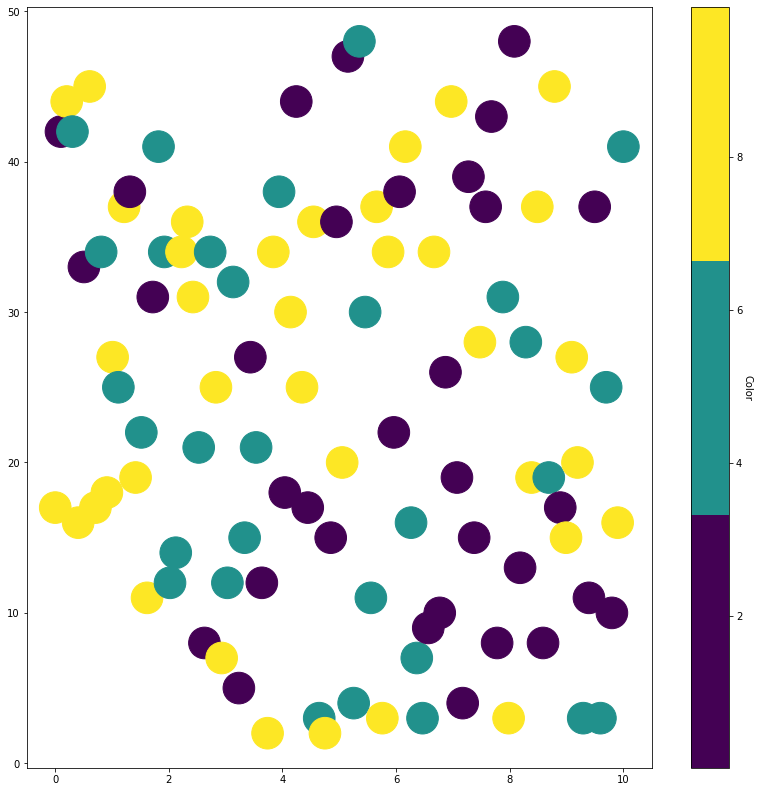

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

x = np.linspace(0, 10, 100)
y = np.random.randint(0, 50, size=100)
z = np.random.rand(100)*10
plt.figure(figsize=(14,14))

## This part from the online resources ---------------
# bounds = [-10,1,3,10]
# colors = ["r", "b", "g"]
# cmap = matplotlib.colors.ListedColormap(colors)
# norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))
## ---------------------------------------------------

viridis= plt.cm.get_cmap('viridis',256)
color= viridis(np.linspace(0,1, 3))

cmap= mpl.colors.ListedColormap(color)
rect = plt.scatter(x, y, s = 1000, c=z, cmap=cmap)#, norm=norm)
cbar = plt.colorbar(rect, spacing="proportional")
cbar.set_label('Color', rotation=270, labelpad=10)

# for i, txt in enumerate(z):
#     plt.annotate(np.around(txt, 1), (x[i], y[i]))'
plt.show()


In [104]:
node_102283= load_node(102283)
node_102283.attributes

{'sealed': True,
 'version': {'core': '1.5.2', 'plugin': '1.1.11-dev4'},
 'exception': "AttributeError: 'ExitCode' object has no attribute 'process_class'\n",
 'process_label': 'combine_imps_wc',
 'process_state': 'excepted',
 'stepper_state_info': 'None'}

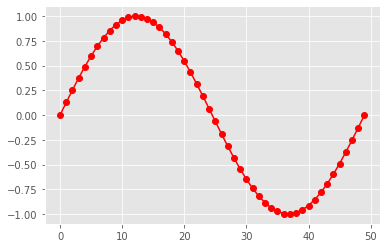

In [4]:
with plt.style.context('ggplot'):
    plt.plot(np.sin(np.linspace(0, 2 * np.pi)), 'r-o')
plt.show()

In [90]:
help_node1= load_node(24887)#combin
help_node2= load_node(24908)#sub_wc
help_node3= load_node(24920)#kkrcalc
help_node4= load_node(102422)
help_node5= load_node(102866)## 102596,102808 # failed parse_Jij: 102971
help_node6= load_node(16336)#sing kkr_imp_sub
def func(impurity1_output_node):
    try:
        imp1_z = impurity1_output_node.get_incoming(node_class=kkr_imp_wc).first().node.inputs.impurity_info.get_dict()['Zimp']
    except AttributeError:
        try:
            impurity1_output_node_combine = impurity1_output_node.get_incoming(node_class=combine_imps_wc).first().node#.get_outgoing(node_class=kkr_imp_sub_wc).first().node.inputs.impurity_info.get_dict()['Zimp']
            imp1_z = impurity1_output_node_combine.get_outgoing(node_class=kkr_imp_sub_wc).first().node.inputs.impurity_info.get_dict()['Zimp']
        except AttributeError:
            try:
                imp1_z = impurity1_output_node.get_incoming(node_class=kkr_imp_sub_wc).first().node.inputs.impurity_info.get_dict()['Zimp']
            except AttributeError:
                    imp1_z = impurity1_output_node.get_incoming(node_class=KkrimpCalculation).first().node.inputs.impurity_info.get_dict()['Zimp']
    return imp1_z

In [76]:
node_104380= load_node(104458)
node_104380.outputs.JijData.get_array('JijData')

array([[-4.18514894e-01,  0.00000000e+00,  0.00000000e+00,
         1.17359542e-02,  5.01783604e-03, -2.42880954e-04,
        -2.26547674e-03, -4.47071611e-03],
       [-8.37029787e-01,  0.00000000e+00,  0.00000000e+00,
        -6.69298594e-07,  1.66658899e-06,  3.67039354e-08,
        -8.20068730e-07, -1.45039959e-06],
       [ 2.09257447e-01,  1.20814843e-01,  9.70368535e-01,
        -3.67773030e-11,  8.87134964e-11, -2.89079659e-11,
         7.70751404e-11,  3.30732018e-11],
       [-4.18514894e-01,  0.00000000e+00,  0.00000000e+00,
         1.18674693e-02,  5.12318855e-03,  1.82296264e-04,
        -2.31748056e-03, -4.56542581e-03],
       [ 6.27772340e-01,  1.20814843e-01,  9.70368535e-01,
         2.89446990e-07,  1.91465032e-07, -8.82239437e-08,
        -1.69638552e-07, -9.90737483e-09],
       [ 1.04628723e+00,  1.20814843e-01,  9.70368535e-01,
        -7.66467780e-11,  1.83008470e-10,  1.81574590e-10,
        -2.28637007e-11,  1.39791456e-13]])

In [77]:
print(node_104380.outputs.JijInfo.get_dict()['text'])

Output Jij values between V impurities:
 i          j           Jij (meV)           Dij(meV)            D/J             i_zimp          j_zimp 
---------------------------------------------------------------------------
  0  15     1.17360e-02     5.01784e-03     4.27561e-01   21   22
  0  26    -6.69299e-07     1.66659e-06    -2.49005e+00   21   21
  0  37    -3.67773e-11     8.87135e-11    -2.41218e+00   21   21
 15  26     1.18675e-02     5.12319e-03     4.31700e-01   22   21
 15  37     2.89447e-07     1.91465e-07     6.61486e-01   22   21
 26  37    -7.66468e-11     1.83008e-10    -2.38769e+00   21   21



In [124]:
struc_node= load_node(234)
struc_node.sites[-7]

<Site: kind name 'Bi' @ 2.1914815820078,1.2652524812963,22.357142232962>

In [128]:
node_24887= load_node(24887)
node_24887.outputs.remote_data_gf.pk

24899

In [126]:
node_40585= load_node(40585)
node_40585.outputs.

In [174]:
group_108= load_group(107)
i = 0
for node in group_108.nodes:
    print(node.pk)
    if i<=0:
        print(f" imp_dict : {node.get_outgoing(node_class=kkr_imp_sub_wc).all()[0].node.get_outgoing(node_class= KkrimpCalculation).all()[0].node.inputs.impurity_info.get_dict()}")
        i += 1

59265
 imp_dict : {'Rcut': 4.0, 'Zimp': 39, 'ilayer_center': 3}
59276
59284
59293
59307
59318
59194
59198
59327
59204
59212
59340
59221
59351
59232
59362
59242
59375
59252


In [176]:
node_59690= load_node(59690)
node_59690.inputs.impurity_info.get_dict()

{'Rcut': 4.0, 'Zimp': 39, 'ilayer_center': 3}